In [1]:
from __future__ import generators
import logging
import glob, os, functools
import sys

import SimpleITK as sitk
from scipy.signal import medfilt
import numpy as np
from numpy import median
import scipy
import nibabel as nib
import skimage
import matplotlib.pyplot as plt
import scipy.misc
from scipy import ndimage
from skimage.transform import resize,rescale
import cv2
import itk
import subprocess
from intensity_normalization.typing import Modality, TissueType
from intensity_normalization.normalize.zscore import ZScoreNormalize

import pandas as pd
import tensorflow as tf
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scripts.densenet_regression import DenseNet
from scripts.unet import get_unet_2D
from scripts.preprocess_utils import load_nii,save_nii, find_file_in_path,iou, enhance_noN4,crop_center, get_id_and_path
from scripts.feret import Calculater
from settings import  target_size_dense_net, target_size_unet, unet_classes, softmax_threshold, major_voting,scaling_factor
from scripts.infer_selection import get_slice_number_from_prediction, funcy
import warnings

warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    


2022-11-28 22:37:47.564337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 22:37:47.725996: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 22:37:47.767897: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 22:37:48.338355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
image_dir = 'data/curated_test/final_test/z/' #'data/z_scored_mris/z_with_pseudo/z/'
model_weight_path = 'model/unet_models/test/Top_Segmentation_Model_Weight.hdf5'
slice_csv_path = 'data/curated_test/final_test/Dataset_test_rescaled.csv' #'data/all_metadata.csv'
output_dir = 'data/curated_test/final_test/preditions_seg_model/'

split_name = 'test'
num_of_slices_to_compare = 2
measure_iou = True
threshold = 0.5 # ie must be present on 3 out of 4 predictions
                

In [3]:
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (n_samples, height, width)
    batch_size = y_true.shape[0]
    mean_dice_channel = 0.
    for i in range(batch_size):
        channel_dice = single_dice_coef(y_true[i, :, :], y_pred_bin[i, :, :])
        mean_dice_channel += channel_dice/(batch_size)
    return mean_dice_channel



def median_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (n_samples, height, width)
    batch_size = y_true.shape[0]
    median_dice_channel = []
    for i in range(batch_size):
        channel_dice = single_dice_coef(y_true[i, :, :], y_pred_bin[i, :, :])
        median_dice_channel.append(channel_dice)
    t=sorted(median_dice_channel)   
    return median(t)

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

def compute_crop_line(img_input,infer_seg_array_2d_1,infer_seg_array_2d_2):
    binary = img_input>-1.7
    binary_smoothed = scipy.signal.medfilt(binary.astype(int), 51)
    img = binary_smoothed.astype('uint8')
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, np.uint8)
    img = cv2.drawContours(mask, contours, -1, (255),1)

    max_y,ind_max = 0,0
    min_y,ind_min = 512,0

    for i in range(0,len(contours[0])):
        x,y = contours[0][i][0]
        if y<=min_y:
            min_y,ind_min = y,i
        if y>=max_y:
            max_y,ind_max = y,i
    print(min_y,contours[0][ind_min][0])
    print(max_y,contours[0][ind_max][0])

    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(img_input, interpolation=None, cmap=plt.cm.Greys_r)
    ax.imshow(infer_seg_array_2d_1,cmap='jet',alpha=0.5)
    ax.imshow(infer_seg_array_2d_2,cmap='jet',alpha=0.5)
    crop_line = (contours[0][ind_min][0][0]+contours[0][ind_max][0][0])/2
    
    ax.plot((crop_line, crop_line),
            (contours[0][ind_min][0][1], contours[0][ind_max][0][1]), lw=1, c='b')

    fig.show()

    return crop_line


In [4]:
# load segmentation model weights
model = get_unet_2D(unet_classes,(target_size_unet[0], target_size_unet[1], 1),\
        num_convs=2,  activation='relu',
        compression_channels=[16, 32, 64, 128, 256, 512],
        decompression_channels=[256, 128, 64, 32, 16])
model.load_weights(model_weight_path)

# load metadata
df_prediction = pd.read_csv(slice_csv_path,index_col=0)
df_prediction = df_prediction[df_prediction['train/test']==split_name]
df_prediction = df_prediction[df_prediction['Ok registered? Y/N']=='Y'].reset_index()
   
print("Testing n =",len(df_prediction))
    

2022-11-28 22:37:48.805768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 22:37:50.406240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39650 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:31:00.0, compute capability: 8.6


Testing n = 47


## Crop tails computations

0
20191118-ST001-MNBCP000080-v05-1-43mo_MR-SE002-T1w data/curated_test/final_test/z/20191118-ST001-MNBCP000080-v05-1-43mo_MR-SE002-T1w/20191118-ST001-MNBCP000080-v05-1-43mo_MR-SE002-T1w.nii data/curated_test/final_test/z/20191118-ST001-MNBCP000080-v05-1-43mo_MR-SE002-T1w/TM.nii.gz
1/1 [==============================] - 0s 32ms/step
0  image: 20191118-ST001-MNBCP000080-v05-1-43mo_MR-SE002-T1w (slice_label: 53 )
no crop line
Dice score TM1 0.81
Dice score TM2 0.78
w crop line
41 [103  41]
160 [ 98 160]
Dice score TM1 0.81
Dice score TM2 0.78
1
20191214-ST001-MNBCP601017-v05-2-43mo_MR-SE002-T1w data/curated_test/final_test/z/20191214-ST001-MNBCP601017-v05-2-43mo_MR-SE002-T1w/20191214-ST001-MNBCP601017-v05-2-43mo_MR-SE002-T1w.nii data/curated_test/final_test/z/20191214-ST001-MNBCP601017-v05-2-43mo_MR-SE002-T1w/TM.nii.gz
1/1 [==============================] - 0s 26ms/step
1  image: 20191214-ST001-MNBCP601017-v05-2-43mo_MR-SE002-T1w (slice_label: 69 )
no crop line
Dice score TM1 0.66
Dice sc

1/1 [==============================] - 0s 22ms/step
15  image: sub-NDARFW670TY2_acq-VNavNorm_T1w (slice_label: 57 )
no crop line
Dice score TM1 0.83
Dice score TM2 0.84
w crop line
24 [108  24]
175 [110 175]
Dice score TM1 0.85
Dice score TM2 0.85
16
sub-NDARWA276AW0_acq-VNav_T1w data/curated_test/final_test/z/sub-NDARWA276AW0_acq-VNav_T1w/sub-NDARWA276AW0_acq-VNav_T1w.nii data/curated_test/final_test/z/sub-NDARWA276AW0_acq-VNav_T1w/TM.nii.gz
1/1 [==============================] - 0s 27ms/step
16  image: sub-NDARWA276AW0_acq-VNav_T1w (slice_label: 52 )
no crop line
Dice score TM1 0.86
Dice score TM2 0.87
w crop line
29 [117  29]
165 [107 165]
Dice score TM1 0.87
Dice score TM2 0.88
17
sub-NDARJW888AJ2_acq-VNavNorm_T1w data/curated_test/final_test/z/sub-NDARJW888AJ2_acq-VNavNorm_T1w/sub-NDARJW888AJ2_acq-VNavNorm_T1w.nii data/curated_test/final_test/z/sub-NDARJW888AJ2_acq-VNavNorm_T1w/TM.nii.gz
1/1 [==============================] - 0s 22ms/step
17  image: sub-NDARJW888AJ2_acq-VNavNorm_T

1/1 [==============================] - 0s 23ms/step
31  image: sub-pixar112_anat_sub-pixar112_T1w (slice_label: 70 )
no crop line
Dice score TM1 0.86
Dice score TM2 0.85
w crop line
23 [94 23]
174 [ 93 174]
Dice score TM1 0.86
Dice score TM2 0.85
32
sub-pixar125_anat_sub-pixar125_T1w data/curated_test/final_test/z/sub-pixar125_anat_sub-pixar125_T1w/sub-pixar125_anat_sub-pixar125_T1w.nii data/curated_test/final_test/z/sub-pixar125_anat_sub-pixar125_T1w/TM.nii.gz
1/1 [==============================] - 0s 31ms/step
32  image: sub-pixar125_anat_sub-pixar125_T1w (slice_label: 85 )
no crop line
Dice score TM1 0.88
Dice score TM2 0.83
w crop line
30 [91 30]
172 [ 97 172]
Dice score TM1 0.88
Dice score TM2 0.84
33
sub-pixar130_anat_sub-pixar130_T1w data/curated_test/final_test/z/sub-pixar130_anat_sub-pixar130_T1w/sub-pixar130_anat_sub-pixar130_T1w.nii data/curated_test/final_test/z/sub-pixar130_anat_sub-pixar130_T1w/TM.nii.gz
1/1 [==============================] - 0s 22ms/step
33  image: sub-p

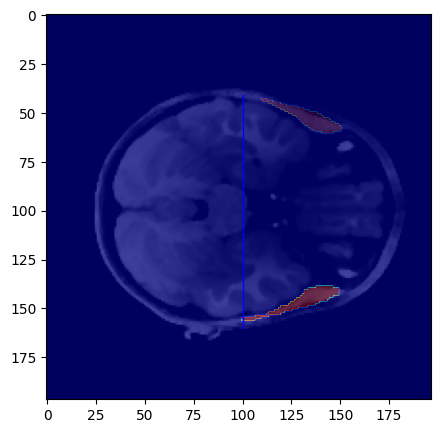

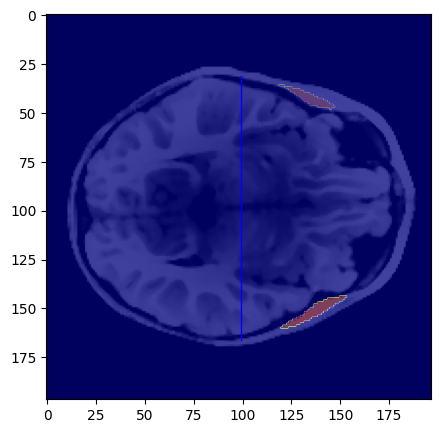

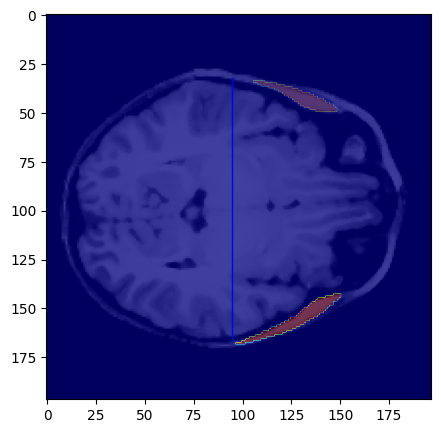

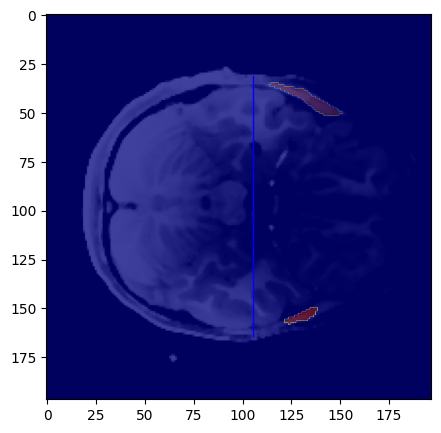

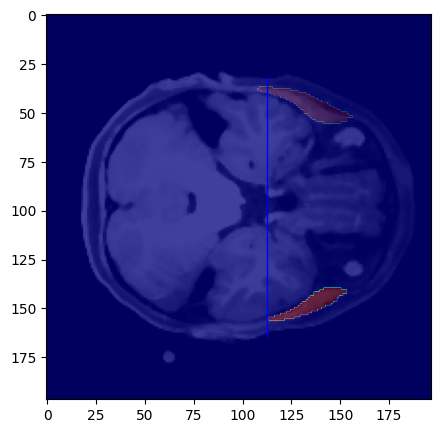

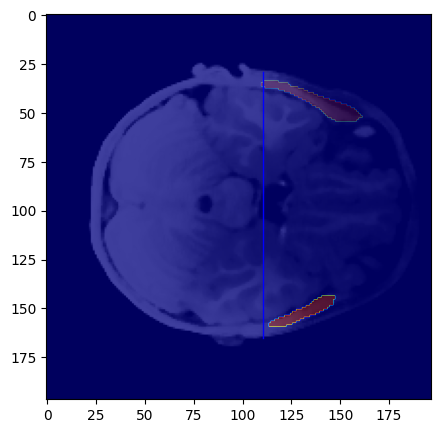

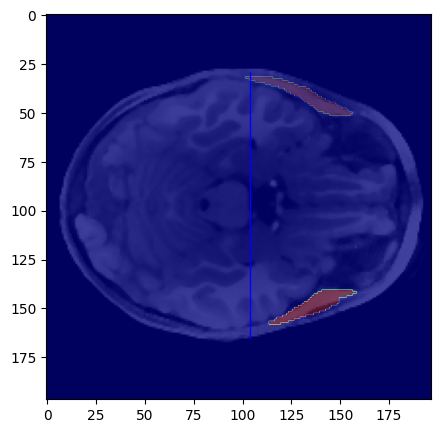

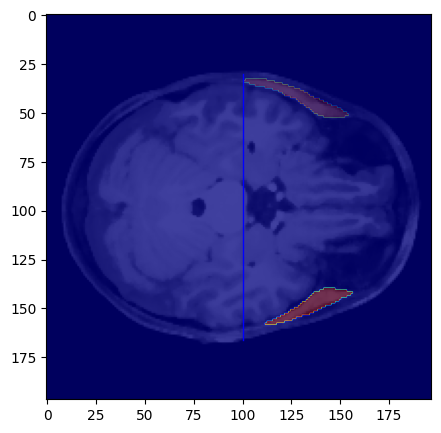

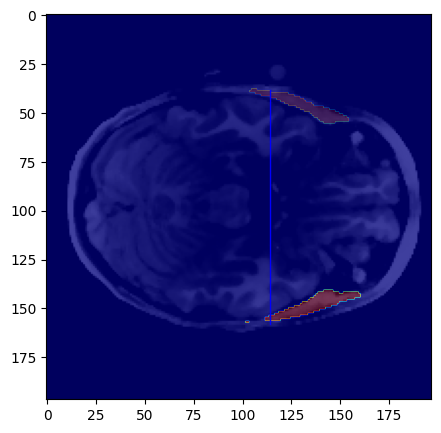

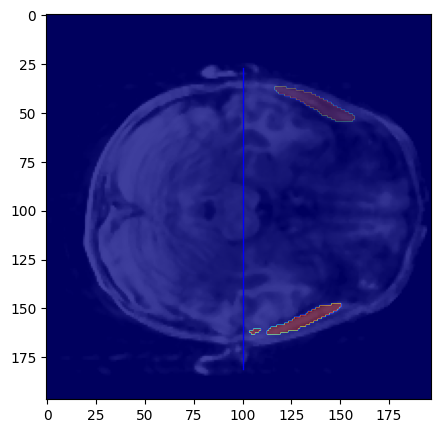

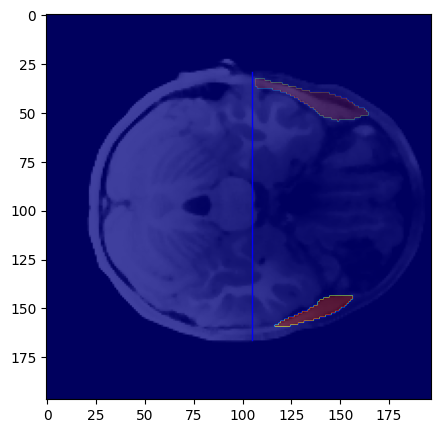

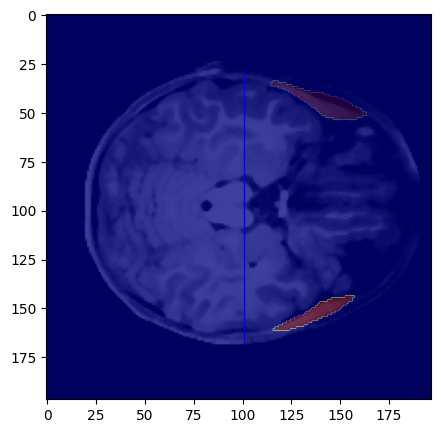

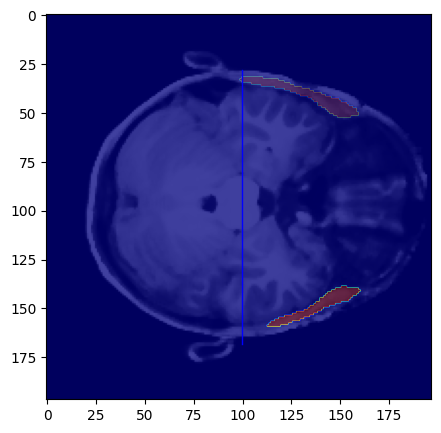

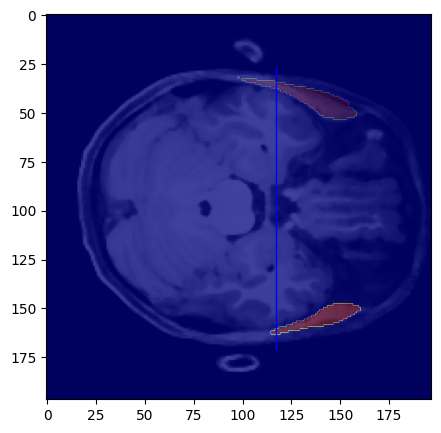

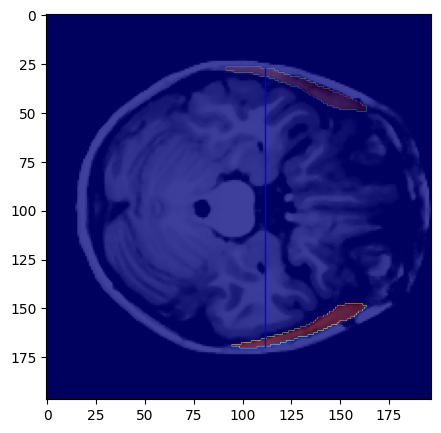

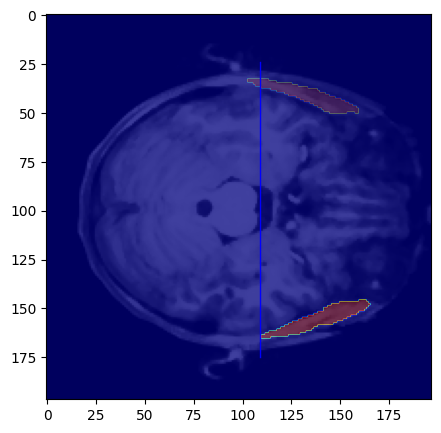

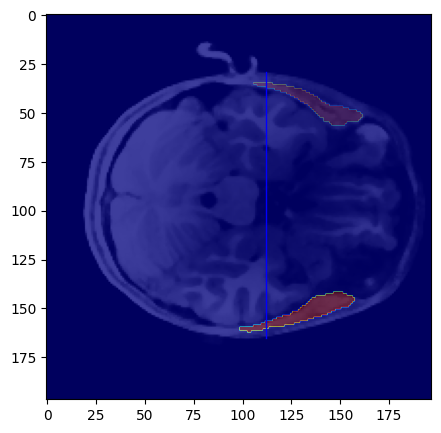

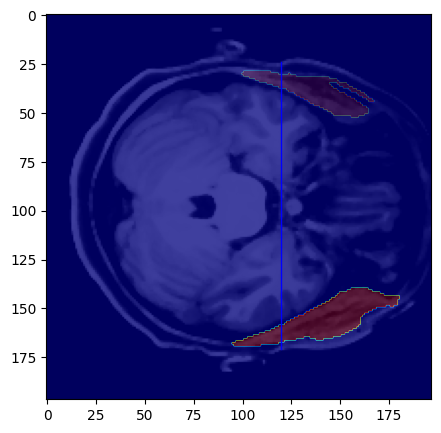

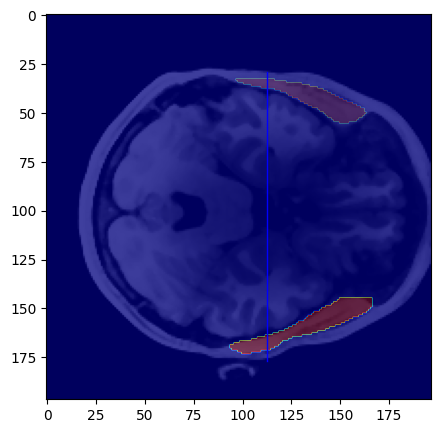

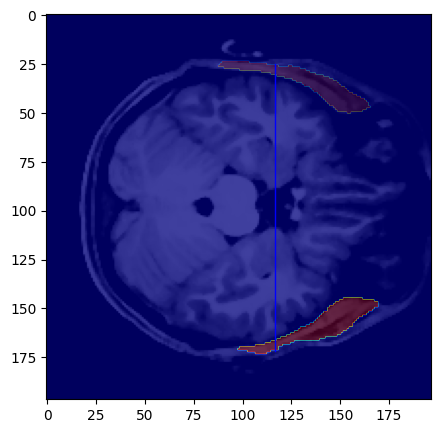

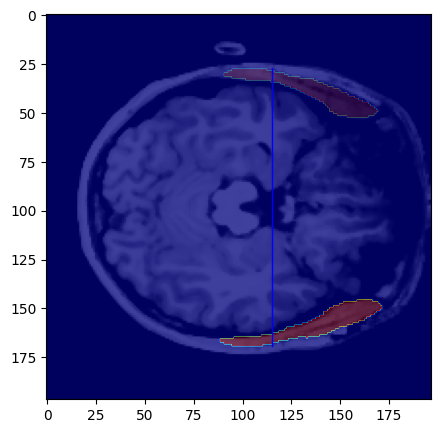

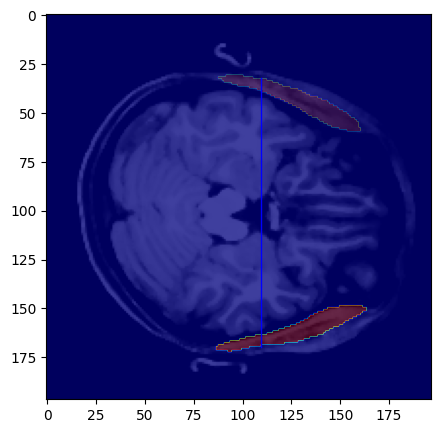

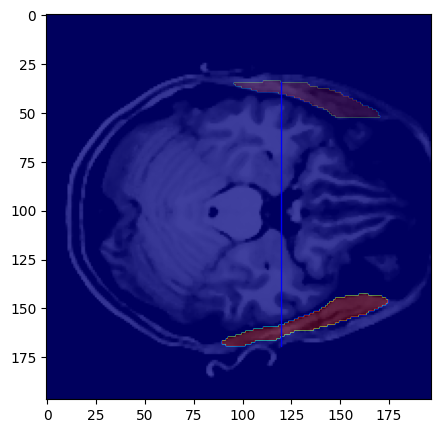

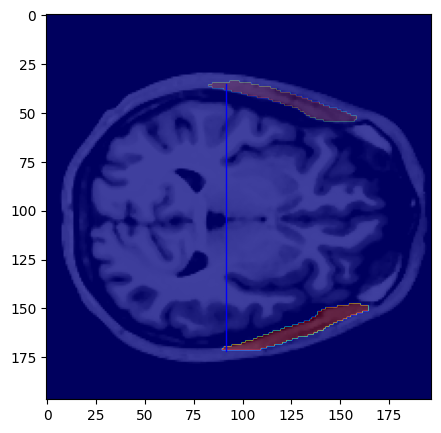

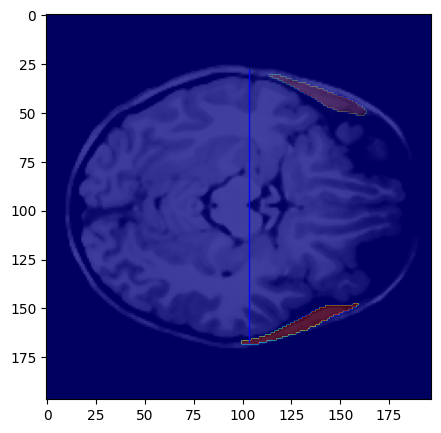

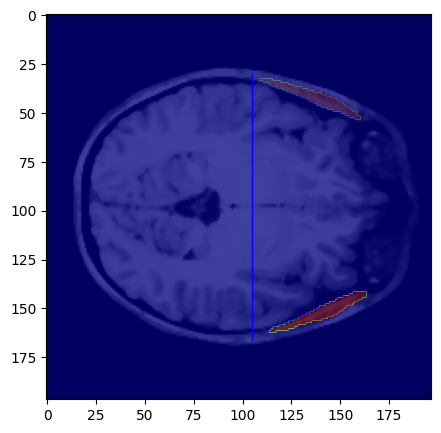

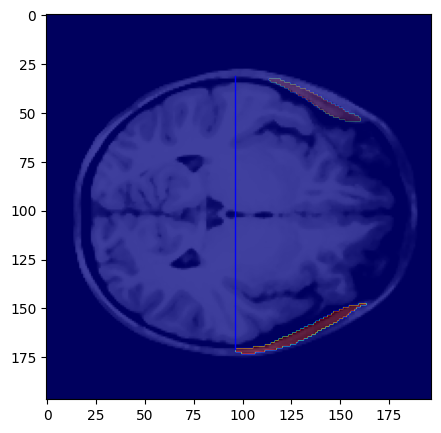

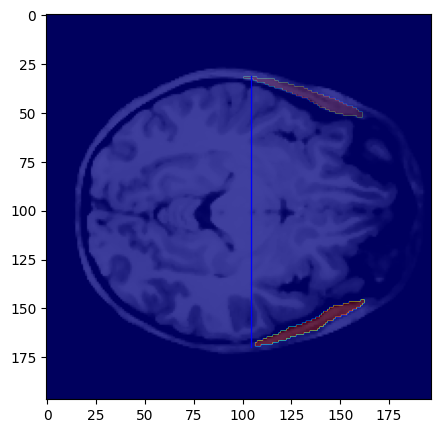

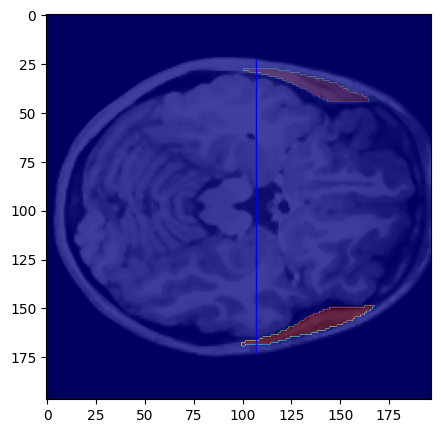

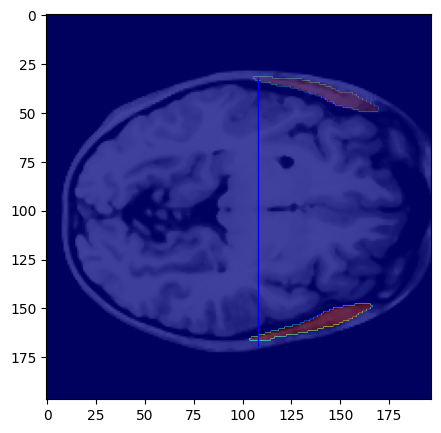

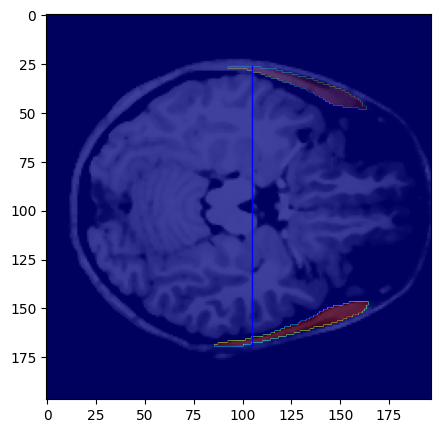

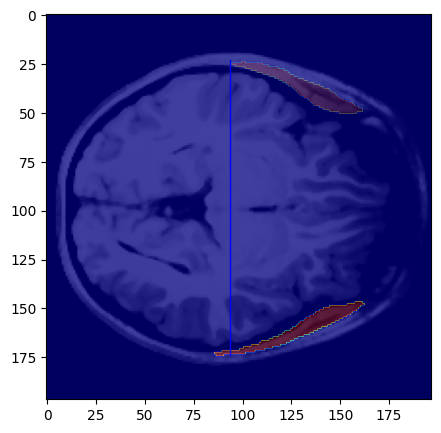

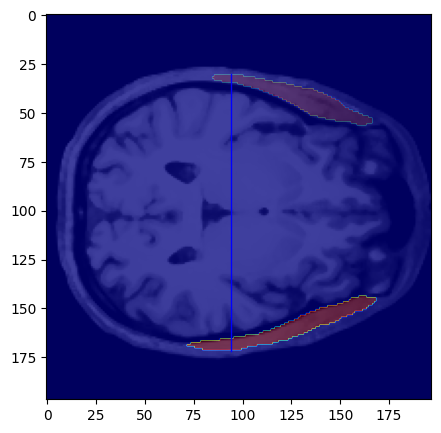

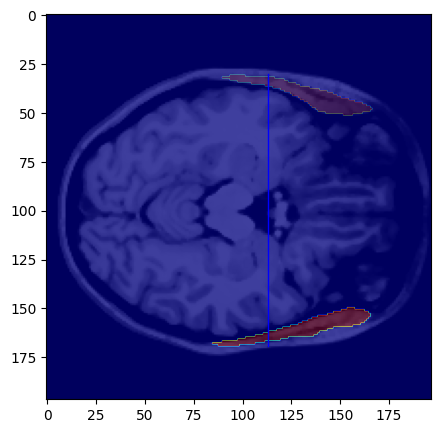

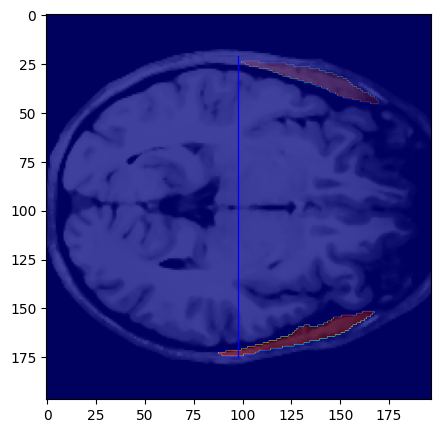

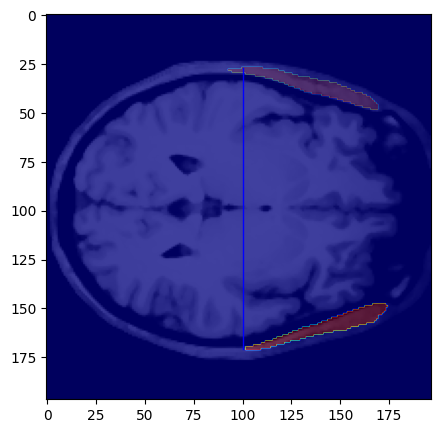

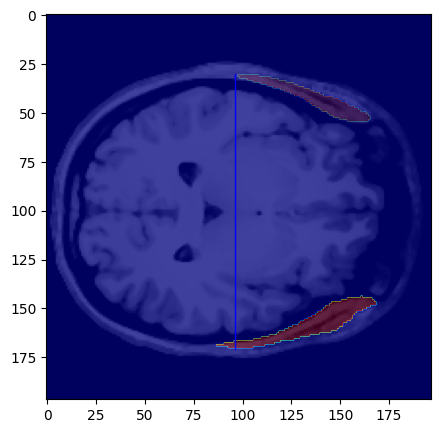

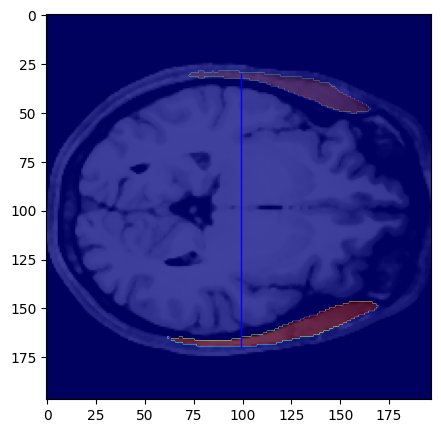

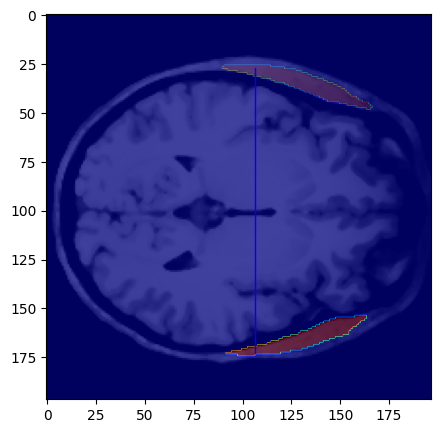

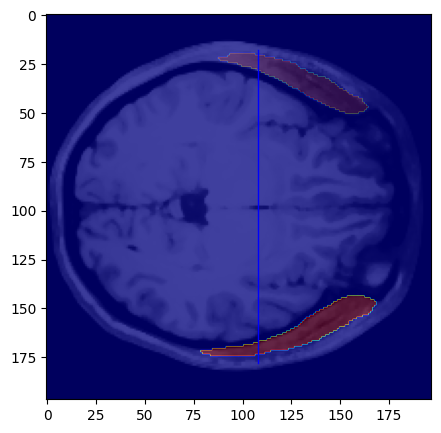

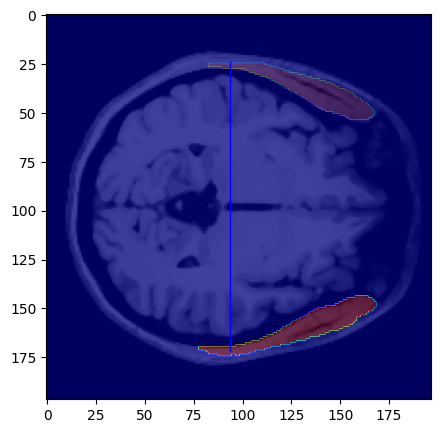

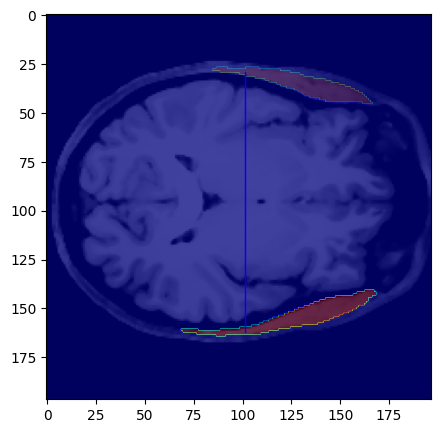

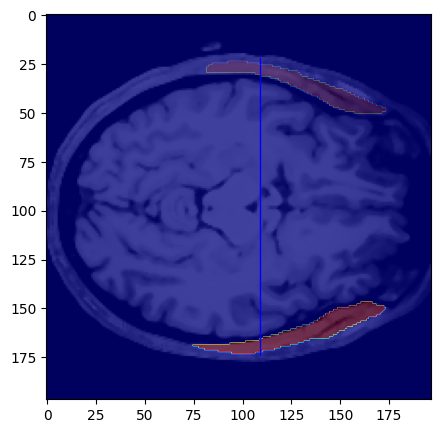

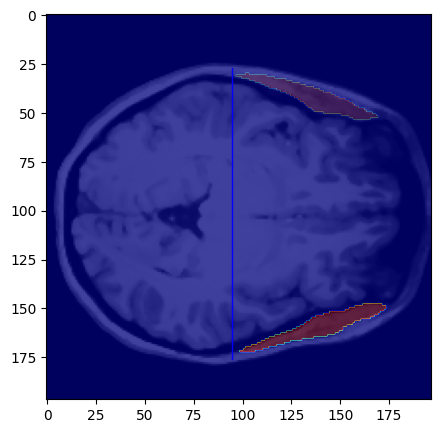

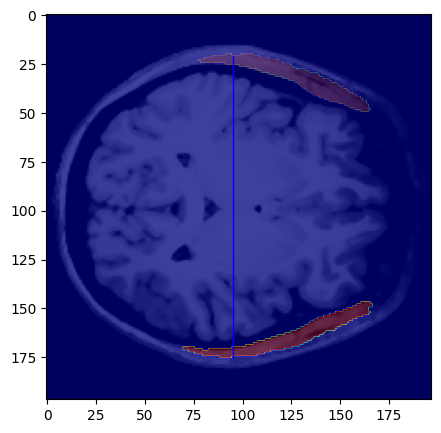

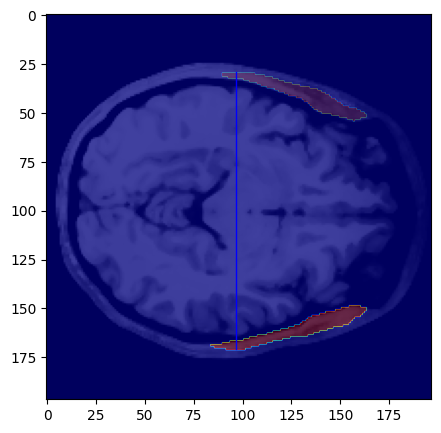

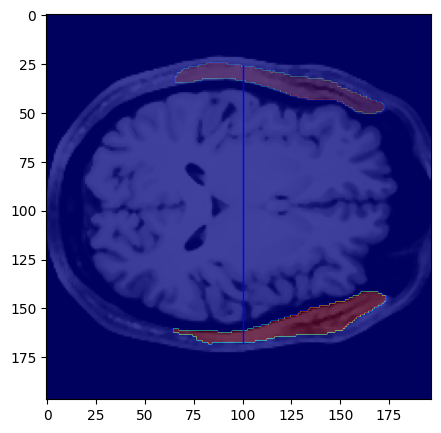

In [39]:
list_true, list_pred = [], []
list_true_line,list_pred_line = [], []
list_csa = []
major_voting=False
for idx, row in df_prediction.iterrows():
    print(idx)
    patient_id, image_path, tm_file,_ = get_id_and_path(row, image_dir, True)
    print(patient_id, image_path, tm_file)
    
    if image_path != 0:
        seg_data, seg_affine = load_nii(tm_file)
            
        # check the orientation - and reorient if needed
        if (np.asarray(nib.aff2axcodes(seg_affine))==['R', 'A', 'S']).all():
            slice_label = np.asarray(np.where(seg_data != 0)).T[0, 2] 
            image_array, affine = load_nii(image_path)
        elif (np.asarray(nib.aff2axcodes(seg_affine))==['L', 'P', 'S']).all():
            ornt = np.array([[0, -1],
                                [1, 1],
                                [2, 1]])
                
            seg = nib.load(tm_file)
            img = nib.load(image_path)
                
            seg = seg.as_reoriented(ornt)
            img = img.as_reoriented(ornt)
                
            image_array, affine = img.get_fdata(), img.affine
            seg_data, seg_affine  = seg.get_fdata(), seg.affine
                
            slice_label = np.asarray(np.where(seg_data != 0)).T[0, 2] 
                
        # create an empty 3d volume to store segmentation in   
        infer_seg_array_3d_1,infer_seg_array_3d_2 = np.zeros(image_array.shape),np.zeros(image_array.shape)
        
        # rescale image into 512x512 for unet 
        image_array_2d = rescale(image_array[:,15:-21,slice_label], scaling_factor).reshape(1,target_size_unet[0],target_size_unet[1],1) 
            
        if major_voting == False:
            img_half_1 = np.concatenate((image_array_2d[:,:256,:,:],np.zeros_like(image_array_2d[:,:256,:,:])),axis=1)
            img_half_2 = np.concatenate((np.zeros_like(image_array_2d[:,256:,:,:]),image_array_2d[:,256:,:,:]),axis=1)

            infer_seg_array_1 = model.predict(img_half_1)
            infer_seg_array_2 = model.predict(img_half_2)

            muscle_seg_1 = (infer_seg_array_1[:,:,:,1] <= softmax_threshold).reshape(1,target_size_unet[0],target_size_unet[1],1)   #<>          
            muscle_seg_2 = (infer_seg_array_2[:,:,:,1] <= softmax_threshold).reshape(1,target_size_unet[0],target_size_unet[1],1)   #<>       
        else:
            img_half_11 = np.concatenate((image_array_2d[:,:256,:,:],np.zeros_like(image_array_2d[:,:256,:,:])),axis=1)
            img_half_21 = np.concatenate((np.zeros_like(image_array_2d[:,:256,:,:]),image_array_2d[:,:256,:,:]),axis=1)
            img_half_12 = np.concatenate((np.zeros_like(image_array_2d[:,256:,:,:]),image_array_2d[:,256:,:,:]),axis=1)
            img_half_22 = np.concatenate((image_array_2d[:,256:,:,:],np.zeros_like(image_array_2d[:,256:,:,:])),axis=1)

            flipped = np.flip(image_array_2d, axis=1)

            flipped_11 = np.concatenate((flipped[:,:256,:,:],np.zeros_like(flipped[:,:256,:,:])),axis=1)
            flipped_21 = np.concatenate((np.zeros_like(flipped[:,:256,:,:]),flipped[:,:256,:,:]),axis=1)
            flipped_12 = np.concatenate((np.zeros_like(flipped[:,256:,:,:]),flipped[:,256:,:,:]),axis=1)
            flipped_22 = np.concatenate((flipped[:,256:,:,:],np.zeros_like(flipped[:,256:,:,:])),axis=1)

            list_of_left_muscle = [img_half_11, img_half_21, flipped_12, flipped_22]
            list_of_right_muscle = [img_half_12,img_half_22, flipped_11, flipped_21]

            list_of_left_muscle_preds = []
            list_of_right_muscle_preds = []

            for image in list_of_left_muscle: 
                infer_seg_array = model.predict(image)
                muscle_seg = infer_seg_array[:,:,:,1].reshape(1,target_size_unet[0],target_size_unet[1],1)               
                list_of_left_muscle_preds.append(muscle_seg)
                    
            for image in list_of_right_muscle: 
                infer_seg_array = model.predict(image)
                muscle_seg = infer_seg_array[:,:,:,1].reshape(1,target_size_unet[0],target_size_unet[1],1)             
                list_of_right_muscle_preds.append(muscle_seg)
                
            list_of_left_muscle_preds_halved = [list_of_left_muscle_preds[0][:,:256,:,:],
                                    list_of_left_muscle_preds[1][:,256:,:,:],
                                    np.flip(list_of_left_muscle_preds[2][:,256:,:,:],axis=1),
                                    np.flip(list_of_left_muscle_preds[3][:,:256,:,:],axis=1)]

            list_of_right_muscle_preds_halved = [list_of_right_muscle_preds[0][:,256:,:,:],
                                    list_of_right_muscle_preds[1][:,:256,:,:],
                                    np.flip(list_of_right_muscle_preds[2][:,:256,:,:],axis=1),
                                    np.flip(list_of_right_muscle_preds[3][:,256:,:,:],axis=1)]
                
            threshold = 0.5 # ie must be present on 3 out of 4 predictions
            left_half_result = np.mean(list_of_left_muscle_preds_halved, axis=0)<=threshold # <>
            right_half_result = np.mean(list_of_right_muscle_preds_halved, axis=0)<=threshold # <>
            muscle_seg_1 = np.concatenate((left_half_result,np.zeros_like(left_half_result)),axis=1)
            muscle_seg_2 = np.concatenate((np.zeros_like(left_half_result),right_half_result),axis=1)

        print(idx,' image:',patient_id,'(slice_label:',slice_label,')')
   
        infer_seg_array_2d_1 = rescale(muscle_seg_1[0],1/scaling_factor)
        infer_seg_array_2d_2 = rescale(muscle_seg_2[0],1/scaling_factor)

        infer_seg_array_3d_1[:,:,slice_label] = np.pad(infer_seg_array_2d_1[:,:,0],[[0,0],[15,21]],'constant',constant_values=0)
        infer_seg_array_3d_2[:,:,slice_label] = np.pad(infer_seg_array_2d_2[:,:,0],[[0,0],[15,21]],'constant',constant_values=0)

        infer_3d_path_1 = output_dir + patient_id + '_1_AI_seg_L3.nii.gz'
        infer_3d_path_2 = output_dir + patient_id + '_2_AI_seg_L3.nii.gz'
        save_nii(infer_seg_array_3d_1, infer_3d_path_1, seg_affine)
        save_nii(infer_seg_array_3d_2, infer_3d_path_2, seg_affine)

        # if GT present, measure TM
        if measure_iou:
            objL_gt_minf, objR_gt_minf, objL_pred_minf, objR_pred_minf = 0,0,0,0
                
            list_true.append(np.concatenate((seg_data[:100,:,slice_label],seg_data[100:,:,slice_label]),axis=0))
            list_pred.append(np.concatenate((infer_seg_array_3d_1[:100,:,slice_label],infer_seg_array_3d_2[100:,:,slice_label]),axis=0))
            
            #print("IOU TM1", round(iou(seg_data[:100,:,slice_label],infer_seg_array_3d_1[:100,:,slice_label]),2)) #might need to swap
            #print("IOU TM2", round(iou(seg_data[100:,:,slice_label],infer_seg_array_3d_2[100:,:,slice_label]),2)) 

            print("no crop line")
            print("Dice score TM1", round(dice_coef(seg_data[:100,:,slice_label],infer_seg_array_3d_1[:100,:,slice_label]),2))
            print("Dice score TM2", round(dice_coef(seg_data[100:,:,slice_label],infer_seg_array_3d_2[100:,:,slice_label]),2))
                    
            print("w crop line")
            crop_line = compute_crop_line(image_array[:,15:-21,slice_label],infer_seg_array_2d_1,infer_seg_array_2d_2)
            print("Dice score TM1", round(dice_coef(seg_data[:100,int(crop_line):,slice_label],infer_seg_array_3d_1[:100,int(crop_line):,slice_label]),2))
            print("Dice score TM2", round(dice_coef(seg_data[100:,int(crop_line):,slice_label],infer_seg_array_3d_2[100:,int(crop_line):,slice_label]),2))
            
            list_true_line.append(np.concatenate((seg_data[:100,int(crop_line):,slice_label],seg_data[100:,int(crop_line):,slice_label]),axis=0))
            list_pred_line.append(np.concatenate((infer_seg_array_3d_1[:100,int(crop_line):,slice_label],infer_seg_array_3d_2[100:,int(crop_line):,slice_label]),axis=0))
            
            #print("IOU TM", round(iou(seg_data[:,:,slice_label],infer_seg_array_3d[:,:,slice_label]),2))
            #print("CSA GT TM1 vs Pred", np.sum(seg_data[:100,:,slice_label]), np.sum(infer_seg_array_3d_1[:100,:,slice_label]))
            #print("CSA GT TM2 vs Pred", np.sum(seg_data[100:,:,slice_label]), np.sum(infer_seg_array_3d_2[100:,:,slice_label]))
                
            objL_gt_minf = round(Calculater(seg_data[:100,:,slice_label], edge=True).minf,2)
            objR_gt_minf = round(Calculater(seg_data[100:,:,slice_label], edge=True).minf,2)
                    
            if np.sum(infer_seg_array_3d_1[:100,:,slice_label])>2:
                objL_pred_minf = round(Calculater(infer_seg_array_3d_1[:100,:,slice_label], edge=True).minf,2)

            if np.sum(infer_seg_array_3d_2[100:,:,slice_label])>2:
                objR_pred_minf = round(Calculater(infer_seg_array_3d_2[100:,:,slice_label], edge=True).minf,2)
            
            CSA_GT_TM1 = np.sum(seg_data[:100,:,slice_label])
            CSA_GT_TM2 = np.sum(seg_data[100:,:,slice_label])
            CSA_PRED_TM1 = np.sum(infer_seg_array_3d_1[:100,:,slice_label])
            CSA_PRED_TM2 = np.sum(infer_seg_array_3d_2[100:,:,slice_label])
            
            
            objL_gt_minf_line = round(Calculater(seg_data[:100,int(crop_line):,slice_label], edge=True).minf,2)
            objR_gt_minf_line = round(Calculater(seg_data[100:,int(crop_line):,slice_label], edge=True).minf,2)
                    
            if np.sum(infer_seg_array_3d_1[:100,int(crop_line):,slice_label])>2:
                objL_pred_minf_line = round(Calculater(infer_seg_array_3d_1[:100,int(crop_line):,slice_label], edge=True).minf,2)

            if np.sum(infer_seg_array_3d_2[100:,int(crop_line):,slice_label])>2:
                objR_pred_minf_line = round(Calculater(infer_seg_array_3d_2[100:,int(crop_line):,slice_label], edge=True).minf,2)
                
            CSA_GT_TM1_line = np.sum(seg_data[:100,int(crop_line):,slice_label])
            CSA_GT_TM2_line = np.sum(seg_data[100:,int(crop_line):,slice_label])
            CSA_PRED_TM1_line = np.sum(infer_seg_array_3d_1[:100,int(crop_line):,slice_label])
            CSA_PRED_TM2_line = np.sum(infer_seg_array_3d_2[100:,int(crop_line):,slice_label])
            #print("TM thickness GT vs Pred",objL_gt_minf, objR_gt_minf, objL_pred_minf, objR_pred_minf)
            list_csa.append([patient_id,
                            CSA_GT_TM1,CSA_GT_TM2,
                            CSA_PRED_TM1,CSA_PRED_TM2,
                            CSA_GT_TM1+CSA_GT_TM2,CSA_PRED_TM1+CSA_PRED_TM2, #"CSA GT SUM", "CSA PRED SUM"
                            objL_gt_minf, objR_gt_minf, objL_pred_minf, objR_pred_minf,
                            objL_gt_minf + objR_gt_minf, objL_pred_minf + objR_pred_minf, # "TMT GT SUM", "TMT PRED SUM"
                            CSA_GT_TM1_line,CSA_GT_TM2_line,
                            CSA_PRED_TM1_line,CSA_PRED_TM2_line,
                            CSA_GT_TM1_line+CSA_GT_TM2_line,CSA_PRED_TM1_line+CSA_PRED_TM2_line, #"CSA GT SUM w line","CSA PRED SUM w line",
                            objL_gt_minf_line, objR_gt_minf_line, objL_pred_minf_line, objR_pred_minf_line,
                            objL_gt_minf_line + objR_gt_minf_line, objL_pred_minf_line + objR_pred_minf_line, # "TMT GT SUM w line ", "TMT PRED SUM w line",
                            ])
            #break
            
df=pd.DataFrame(np.asarray(list_csa))
df.to_csv(output_dir+"csa_w_line_nomj.csv", header=["ID","CSA GT TM1","CSA GT TM2",
                                            "CSA PRED TM1","CSA PRED TM2",
                                            "CSA GT SUM", "CSA PRED SUM",
                                            "TM GT1","TM GT2","TM PRED1","TM PRED2",
                                            "TMT GT SUM", "TMT PRED SUM", 
                                            "CSA GT TM1 w line","CSA GT TM2 w line",
                                            "CSA PRED TM1 w line","CSA PRED TM2 w line",
                                            "CSA GT SUM w line","CSA PRED SUM w line",
                                            "TM GT1 w line ","TM GT2 w line","TM PRED1 w line","TM PRED2 w line",
                                            "TMT GT SUM w line ", "TMT PRED SUM w line", 
                                             ])
    


In [40]:
print()
print("Mean dice TM:", round(mean_dice_coef(np.asarray(list_true),np.asarray(list_pred)),3))
print("Median dice TM :", round(median_dice_coef(np.asarray(list_true),np.asarray(list_pred)),3))

find_max_y = 0
for i in list_true_line:
    if np.shape(i)[1]>find_max_y:
        find_max_y = np.shape(i)[1]

list_true_line_padded,list_pred_line_padded = [],[]
for i in list_true_line:
    if np.shape(i)[1]>find_max_y:
        find_max_y = np.shape(i)[1]
    #print(np.shape(np.pad(i, pad_width=((0, 0), (0, find_max_y-np.shape(i)[1])), mode='constant')))
    list_true_line_padded.append(np.pad(i, pad_width=((0, 0), (0, find_max_y-np.shape(i)[1])), mode='constant'))    

for i in list_pred_line:
    if np.shape(i)[1]>find_max_y:
        find_max_y = np.shape(i)[1]
    #print(np.shape(np.pad(i, pad_width=((0, 0), (0, find_max_y-np.shape(i)[1])), mode='constant')))
    list_pred_line_padded.append(np.pad(i, pad_width=((0, 0), (0, find_max_y-np.shape(i)[1])), mode='constant'))    

print()
print("Mean dice TM w line:", round(mean_dice_coef(np.asarray(list_true_line_padded),np.asarray(list_pred_line_padded)),3))
print("Median dice TM w line:", round(median_dice_coef(np.asarray(list_true_line_padded),np.asarray(list_pred_line_padded)),3))
print()


Mean dice TM: 0.835
Median dice TM : 0.848

Mean dice TM w line: 0.843
Median dice TM w line: 0.856

